**Final Group Project Topic: Customers Behaviors In Campaign Marketing**

1) People.

ID: The customer's unique identifier.
Year_Birth: The customer's birth year.
Education: The customer's educational level
Marital Status: The customer's marital status.
Income: The customer's annual household income
Kidhome: The number of children in the customer's home.
Teenhome refers to the number of teens in the customer's household. Dt_Customer: Date of customer enrollment with the company.
Recency is the number of days since the customer's last purchase.
Complaint: 1 if the customer complained during the last two years; 0 otherwise.

2) Product:
MntWines: Amount spent on wine over the last two years
MntFruits: Amount spent on fruits during the last two years.
MntMeatProducts: Amount spent on meat in the past two years.
MntFishProducts: Amount spent on fish in the past two years
MntSweetProducts: Amount spent on sweets in the past two years.
MntGoldProds: Amount spent on gold in the last two years.

3) Promotion
NumDealsPurchases: Number of purchases made with a discount
AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

4) Place
NumWebPurchases: The number of purchases done on the company's website.
NumCatalogPurchases: The total number of catalog purchases
NumStorePurchases: The number of purchases made directly at retailers
NumWebVisitsMonth: The number of visits to the company's website within the last month.


In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix # for matrix plotting
import matplotlib.pyplot as plt # for plot
from matplotlib import colors
import numpy as np
from sklearn.svm import SVC
from numpy import *
from pylab import *
from numpy.random import *
from scipy.optimize import * # for curve fitting
from scipy.stats import * # for spicy linear regression
from sklearn.linear_model import LinearRegression # for linear regression
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D # for 3D plot
import seaborn as sns

# import data
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/"

# read line in file
data = pd.read_csv('marketing_campaign.csv', sep = '\t')
print("Number of data:", len(data))


# Shorten the data with combine relative data together
# Total spendings on the items
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]
# Deriving living situation by marital status "Alone" & "Partner"
data["Status_Shorten"] = data["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone",})
# Calculate the customer age
data["Current_Age"] = 2024 - data["Year_Birth"]
# Feature reflecting the total number of children in the home
data["Family_Have_Kids"] = data["Kidhome"] + data["Teenhome"]
# Check if the person is parent or not
data["Parent_Checking"] = np.where(data.Family_Have_Kids> 0, 1, 0)
# Calculate the total family members between each status
data["Family_Size"] = data["Status_Shorten"].replace({"Alone": 1, "Partner": 2}) + data["Family_Have_Kids"]
# Deriving education type to "Graduate" & "Ungraduate"
data["Education_Shorten"] = data["Education"].replace({"Basic": "Undergraduate","2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
#Creating a feature to get a sum of accepted promotions
data["Promo_Accepted_Sum"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
# eliminate unnecessary variables or the variables that already be shorten/combine
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis = 1)

# check data type and total rows and columns
data.head()
data.info()
# clean data by eliminate N/A values
data = data.dropna()

Number of data: 2240
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2240 non-null   int64  
 3   Teenhome             2240 non-null   int64  
 4   Recency              2240 non-null   int64  
 5   MntWines             2240 non-null   int64  
 6   MntFruits            2240 non-null   int64  
 7   MntMeatProducts      2240 non-null   int64  
 8   MntFishProducts      2240 non-null   int64  
 9   MntSweetProducts     2240 non-null   int64  
 10  MntGoldProds         2240 non-null   int64  
 11  NumDealsPurchases    2240 non-null   int64  
 12  NumWebPurchases      2240 non-null   int64  
 13  NumCatalogPurchases  2240 non-null   int64  
 14  NumStorePurchases    2240 non-null   int64  
 15  NumWebVisitsMonth

1) Count for the total variables of the dataset
2) Mean values for the average of the dataset
3) Calculate minimum and maximum of the dataset
4) 25% & 50% & 75% to seperate the dataset for each sections

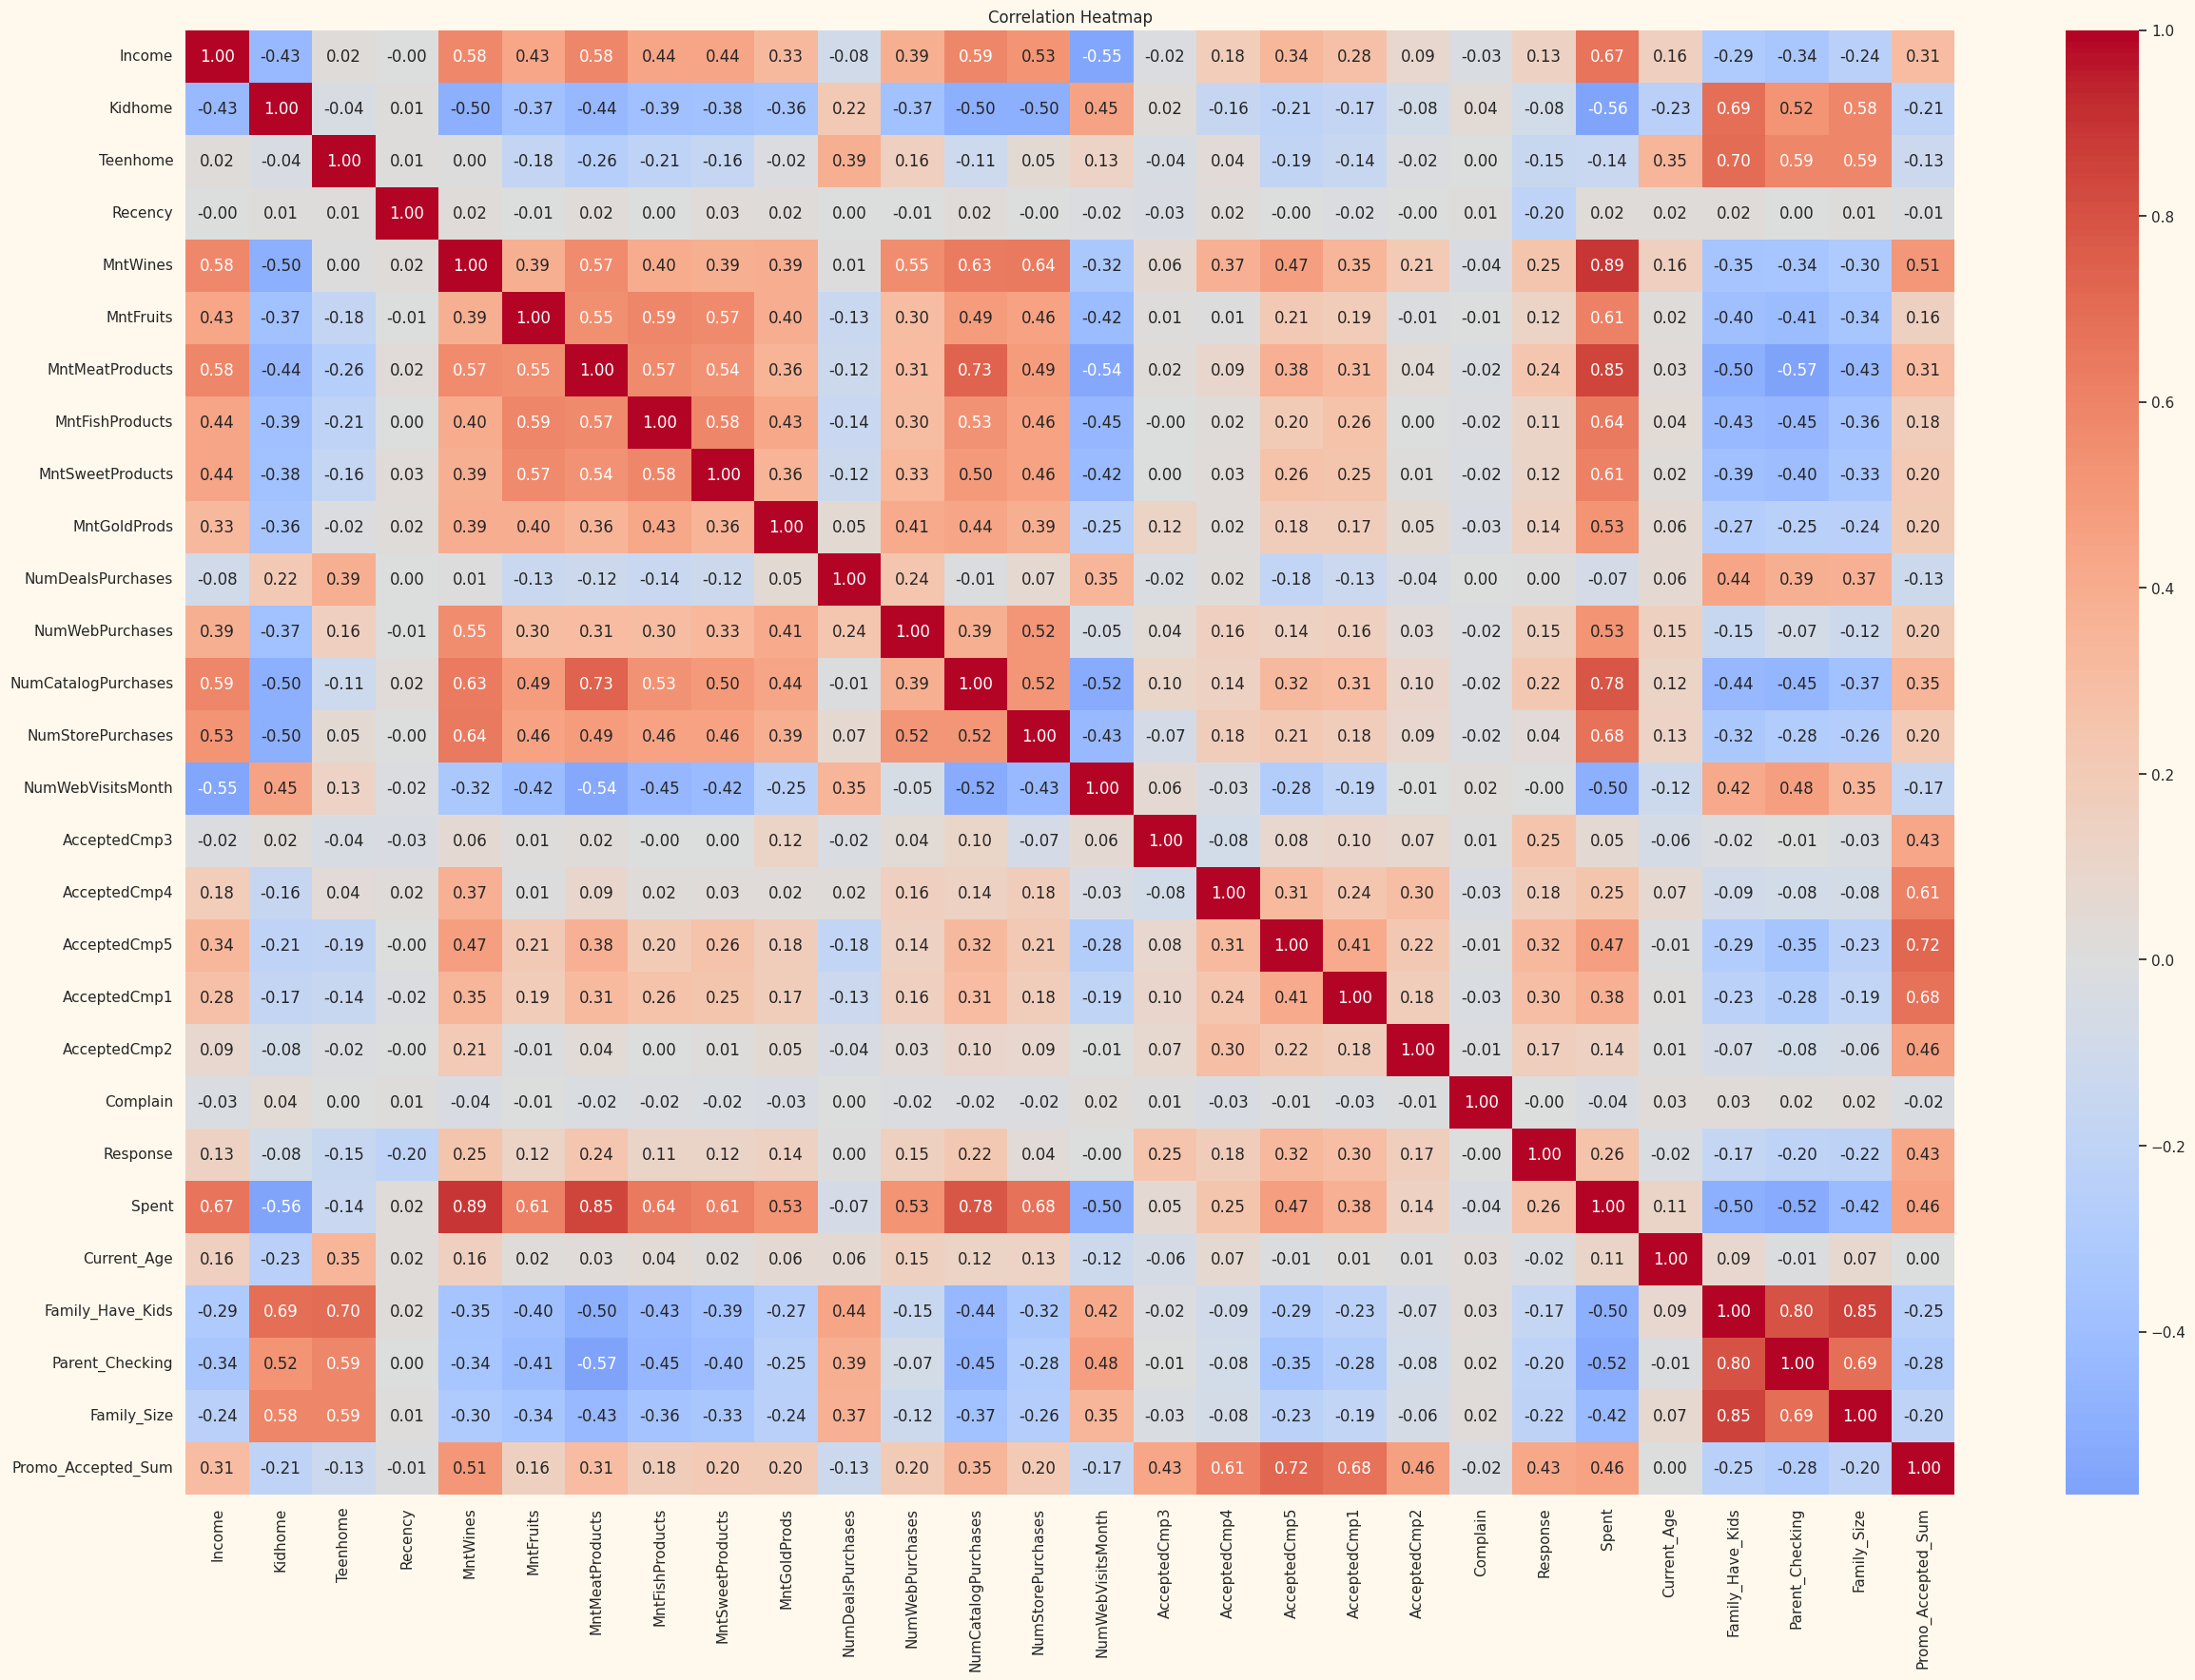

In [ ]:
#correlation matrix
numeric_data = data.select_dtypes(include=[np.number])
corrmat = numeric_data.corr()
plt.figure(figsize = (30, 20))
sns.heatmap(corrmat, annot = True, fmt = ".2f", cmap = 'coolwarm', center = 0)
plt.title("Correlation Heatmap")
plt.show()

1) Positive Correlations: Several variables show strong positive correlations, as represented by the warm red and orange colors. For example, the Spent variable seems to have a substantial positive association with MntWines, MntMeatProducts, MntFishProducts, MntSweetProducts, and MntGoldProds. This shows that when spending on these individual product categories increases, so does overall spending (Spent).

2) Cooler colors, like blue, suggest negative connections. For example, Recency shows a moderately negative connection with various Mnt (Amount Spent) variables such as MntWines and MntFruits. This could signal that recent purchasers spent less in these categories.

4) Uncorrelated Features: Correlations between neutral colors close to white, such as Kidhome and MntFishProducts or Teenhome and NumCatalogPurchases, indicate that these feature pairs have little to no linear relationship. The colors' intensity is subdued, demonstrating that changes in one aspect may not always result in expected changes in the other.

5) Perspectives for Business Strategy:
- The positive associations between different categories of product expenditure and total amount spent may indicate that customers who purchase a variety of products spend more money overall. Marketing methods could include cross-selling to enhance client basket size.

- The negative association between Recency and spending may indicate that recent consumers should be targeted for follow-up marketing activities; they appear to spend less but buy more.

- Demographic indicators such as Current_Age, Family_Have_Kids, Parent_Checking, and Family_Size have various degrees of connection with buying behaviors, which could inform targeted marketing efforts. For example, higher family sizes have a strong negative connection with Kidhome, maybe due to children growing up and leaving home.

6) Annotations:
The annotations on the heatmap provide precise correlation values, allowing for a more detailed understanding of the relationships. For example, MntWines has a correlation value of 0.67 with Spent, showing a high positive association, whilst NumWebVisitsMonth has a correlation of -0.55 with Spent, indicating a moderate negative correlation.



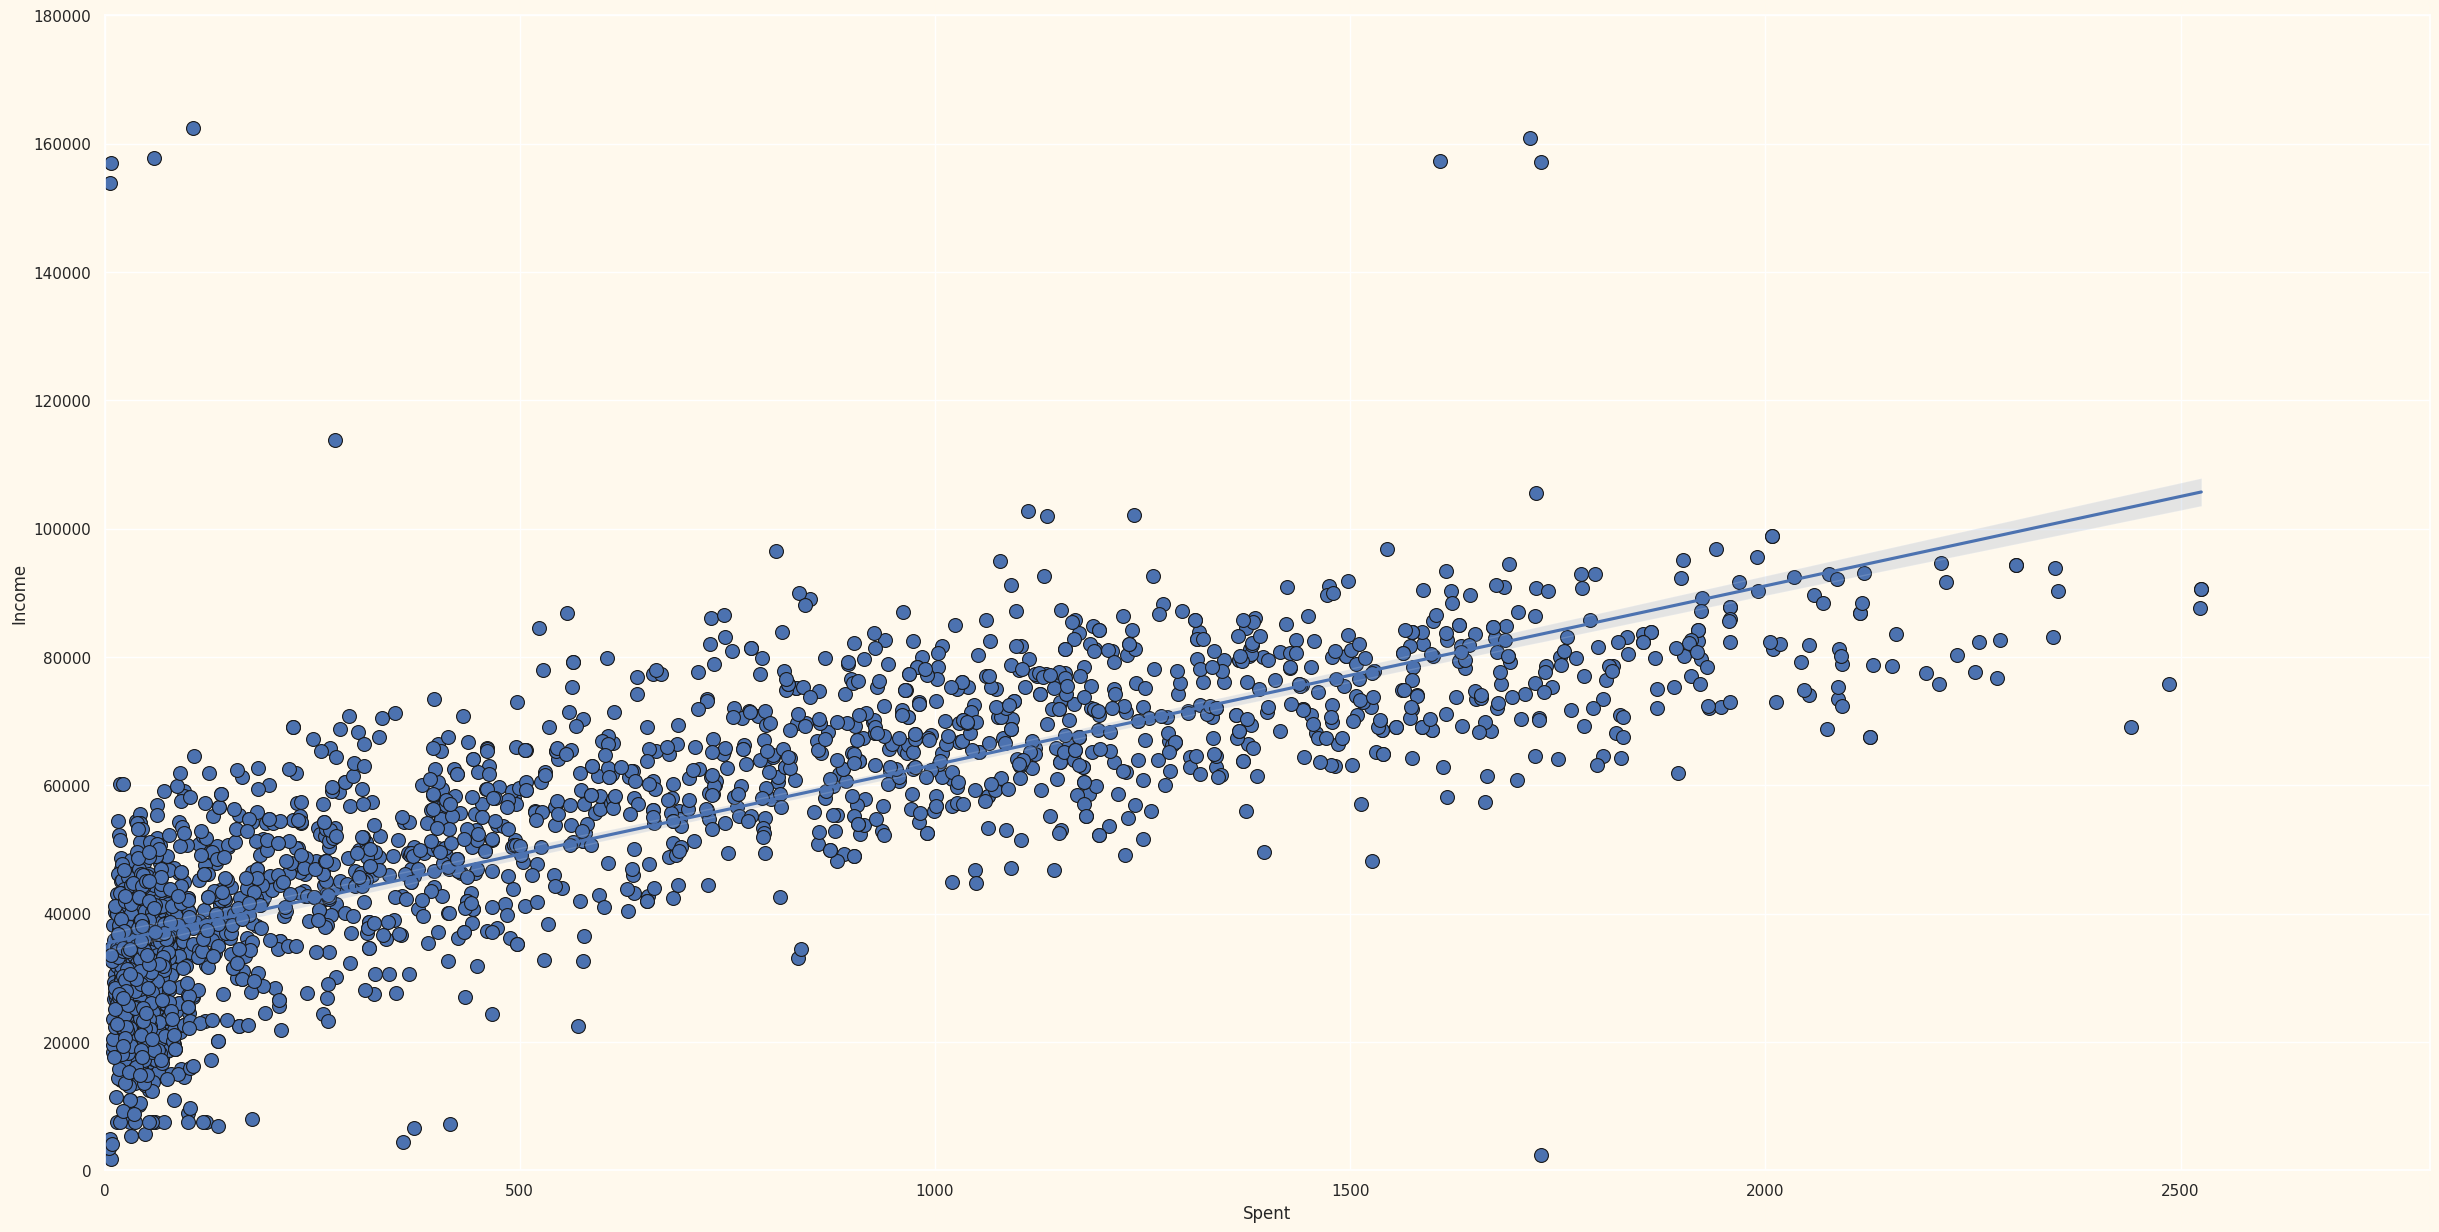

In [ ]:
plt.figure(figsize = (30, 15))
plot = sns.regplot(x = data["Spent"], y = data["Income"], scatter_kws = {'s': 100, 'alpha': 1, 'edgecolor': 'k', 'linewidth': 0.8})
# set x and y limit to make the plot more clear
plot.set(ylim = (0, 180000))
plot.set(xlim = (0, 2800))
plt.show()

In [ ]:
# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables in the dataset:", object_cols)

#Label Encoding the object dtypes
object_type_change = LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(object_type_change.fit_transform)

print("All features are now numerical")

data_cp = data.copy()
column_delete = ['Response', 'Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
data_cp = data_cp.drop(column_delete, axis = 1)

scale = StandardScaler()
scale.fit(data_cp)
scaled_data= pd.DataFrame(scale.transform(data_cp), columns = data_cp.columns)

Categorical variables in the dataset: ['Education', 'Status_Shorten', 'Education_Shorten']
All features are now numerical


In [ ]:
dimension_reduce = PCA(n_components = 3)
dimension_fit = pd.DataFrame(dimension_reduce.fit_transform(scaled_data), columns=["col1", "col2", "col3"])

# Displaying the statistical summary of PCA components
dimension_fit.describe().T

# Initiating the Agglomerative Clustering model
optimal_number = AgglomerativeClustering(n_clusters = 4)

# Fit model and predict clusters
yhat_axis = optimal_number.fit_predict(dimension_fit)
dimension_fit['Groups'] = yhat_axis

# Adding the Clusters feature to the original dataframe
data['Groups'] = yhat_axis

# Optionally, you can check the first few rows to confirm the cluster column is added
print(data.head())

   Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0          2  58138.0        0         0       58       635         88   
1          2  46344.0        1         1       38        11          1   
2          2  71613.0        0         0       26       426         49   
3          2  26646.0        1         0       26        11          4   
4          4  58293.0        1         0       94       173         43   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Response  Spent  \
0              546              172                88  ...         1   1617   
1                6                2                 1  ...         0     27   
2              127              111                21  ...         0    776   
3               20               10                 3  ...         0     53   
4              118               46                27  ...         0    422   

   Status_Shorten  Current_Age  Family_Have_Kids  Parent_Checking  \
0          

In [ ]:
data.shape

(2216, 32)

In [ ]:
# show basics informations of all datas
# data.describe()

data[['Current_Age', 'Family_Size', 'Parent_Checking', 'Groups', 'Income', 'Spent', "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].describe()

,Current_Age,Family_Size,Parent_Checking,Groups,Income,Spent,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,55.179603,2.592509,0.714350,1.425542,52247.251354,607.075361,0.064079,0.013538,0.073556,0.074007,0.073105
std,11.985554,0.905722,0.451825,1.122259,25173.076661,602.900476,0.244950,0.115588,0.261106,0.261842,0.260367
min,28.000000,1.000000,0.000000,0.000000,1730.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,2.000000,0.000000,0.000000,35303.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,3.000000,1.000000,1.000000,51381.500000,396.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,65.000000,3.000000,1.000000,2.000000,68522.000000,1048.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131.000000,5.000000,1.000000,3.000000,666666.000000,2525.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<ipython-input-10-19773ac497e3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x = data["Groups"], palette = pal)


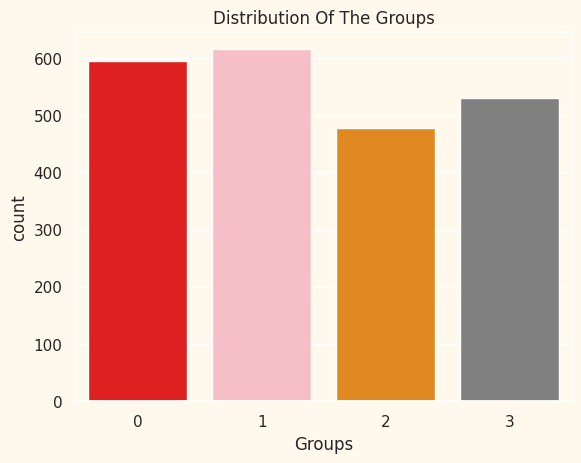

In [ ]:
#Plotting countplot of clusters
pal = ["red", "lightpink", "darkorange", "gray"]
pl = sns.countplot(x = data["Groups"], palette = pal)
pl.set_title("Distribution Of The Groups")
plt.show()

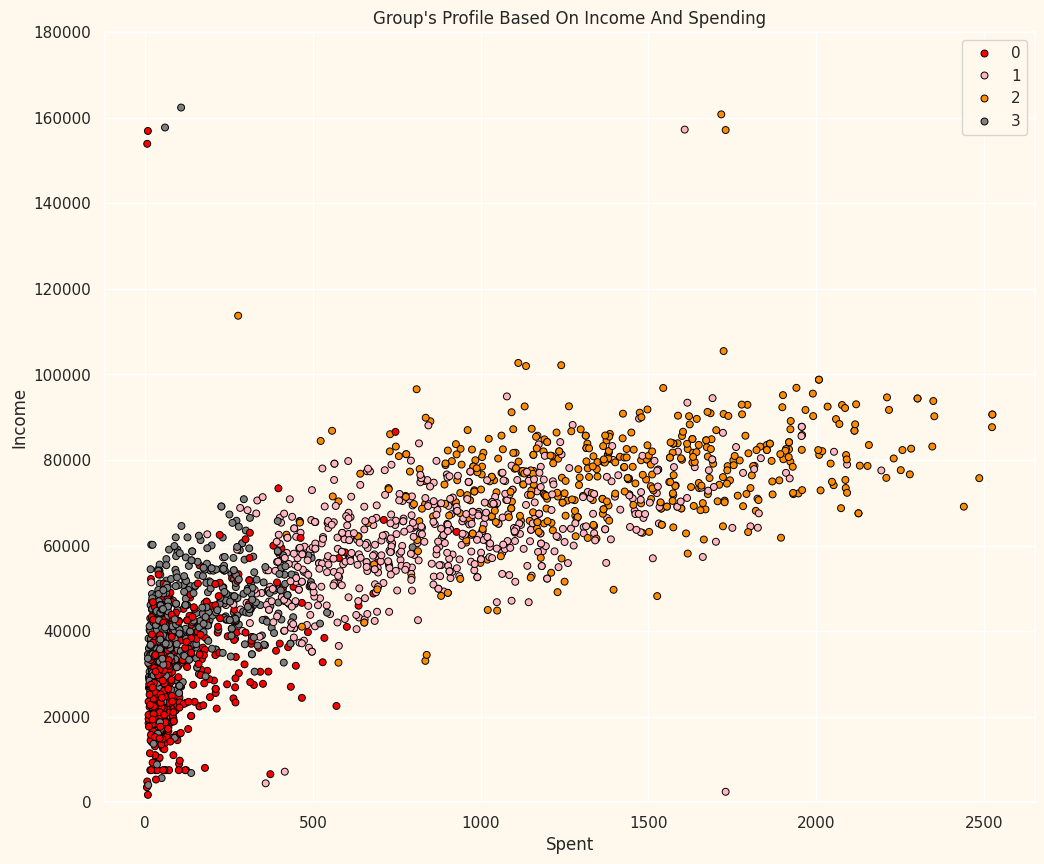

In [ ]:
 plt.figure(figsize = (12, 10))
pl = sns.scatterplot(data = data,x = data["Spent"], y = data["Income"], hue = data["Groups"], palette = pal, edgecolor = "black", linewidth = 0.7, alpha = 1, s = 25)
pl.set_title("Group's Profile Based On Income And Spending")
pl.set(ylim = (0, 180000))
plt.legend()
plt.show()

Group 0: High Spending and Average Income
Group 1: High Spending and Income
Group 2: Low Spending and Income
Group 3: High Spending and Low Income


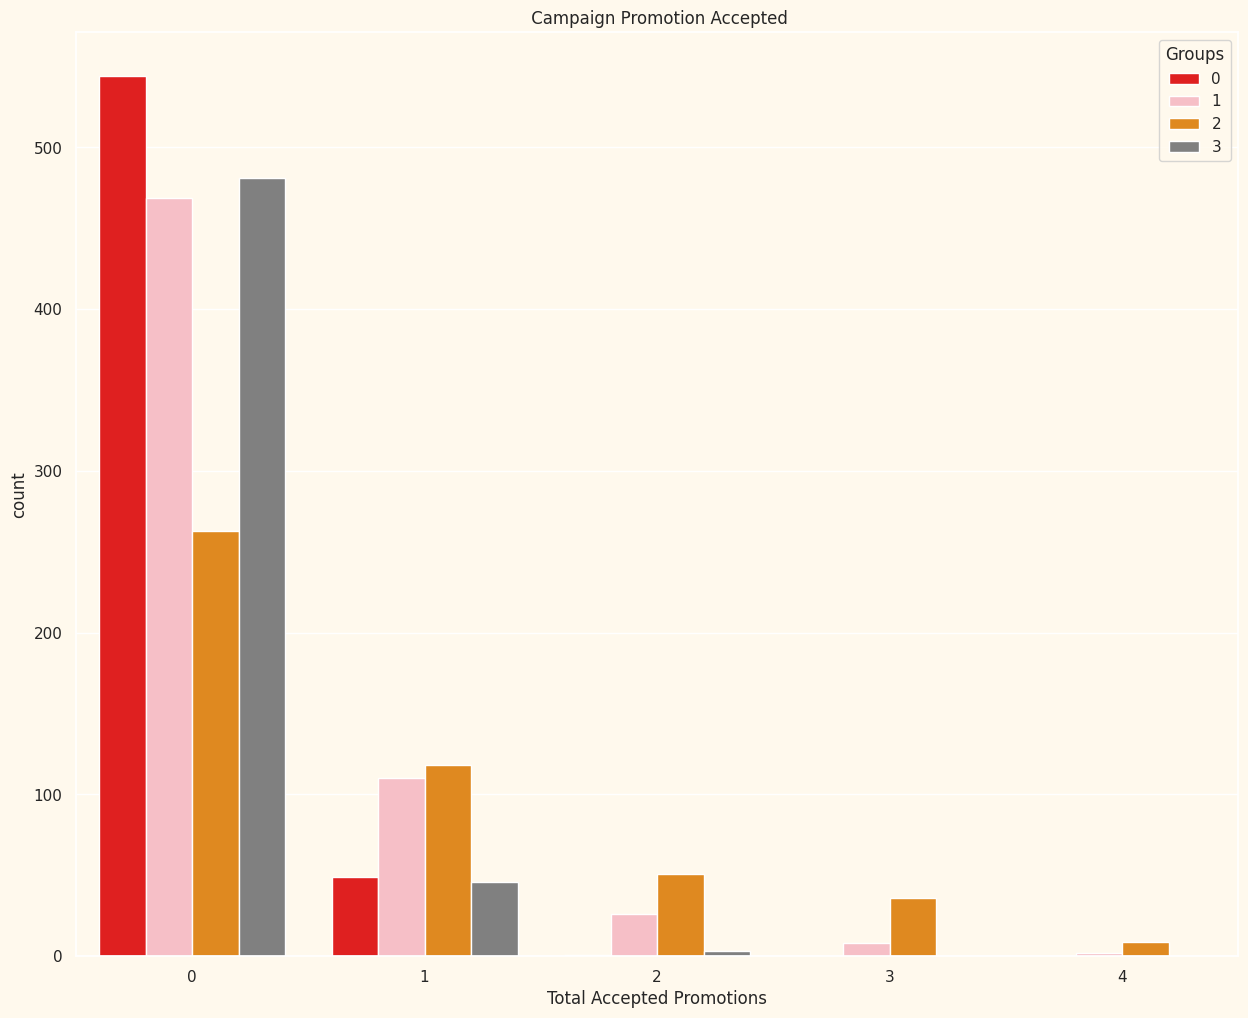

In [ ]:

#Plotting count of total campaign accepted.
plt.figure(figsize = (15, 12))
pl = sns.countplot(x = data["Promo_Accepted_Sum"],hue = data["Groups"], palette = pal)
pl.set_title(" Campaign Promotion Accepted")
pl.set_xlabel("Total Accepted Promotions")
plt.show()

In [ ]:
data.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Spent', 'Status_Shorten',
       'Current_Age', 'Family_Have_Kids', 'Parent_Checking', 'Family_Size',
       'Education_Shorten', 'Promo_Accepted_Sum', 'Groups'],
      dtype='object')

In [ ]:
data2=data[['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','Complain', 'Spent', 'Status_Shorten','Current_Age', 'Parent_Checking','Family_Size','Education_Shorten', 'Promo_Accepted_Sum','Response']]
data2.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Spent,Status_Shorten,Current_Age,Parent_Checking,Family_Size,Education_Shorten,Promo_Accepted_Sum,Response
0,58138.0,58,3,8,10,4,7,0,1617,0,67,0,1,0,0,1
1,46344.0,38,2,1,1,2,5,0,27,0,70,1,3,0,0,0
2,71613.0,26,1,8,2,10,4,0,776,1,59,0,2,0,0,0
3,26646.0,26,2,2,0,4,6,0,53,1,40,1,3,0,0,0
4,58293.0,94,5,5,3,6,5,0,422,1,43,1,3,1,0,0


In [ ]:
# Get unique values from all the columns
data2.apply(lambda x: x.unique())

Income                 [58138.0, 46344.0, 71613.0, 26646.0, 58293.0, ...
Recency                [58, 38, 26, 94, 16, 34, 32, 19, 68, 59, 82, 5...
NumDealsPurchases      [3, 2, 1, 5, 4, 15, 7, 6, 9, 0, 8, 10, 13, 11,...
NumWebPurchases        [8, 1, 2, 5, 6, 7, 4, 3, 11, 0, 10, 9, 23, 27,...
NumCatalogPurchases       [10, 1, 2, 0, 3, 4, 6, 28, 9, 5, 8, 7, 11, 22]
NumStorePurchases         [4, 2, 10, 6, 7, 0, 3, 8, 5, 12, 9, 13, 11, 1]
NumWebVisitsMonth      [7, 5, 4, 6, 8, 9, 20, 2, 3, 1, 10, 0, 14, 19,...
Complain                                                          [0, 1]
Spent                  [1617, 27, 776, 53, 422, 716, 590, 169, 46, 49...
Status_Shorten                                                    [0, 1]
Current_Age            [67, 70, 59, 40, 43, 57, 53, 39, 50, 74, 48, 6...
Parent_Checking                                                   [0, 1]
Family_Size                                              [1, 3, 2, 4, 5]
Education_Shorten                                  

In [ ]:
data2.dtypes

Income                 float64
Recency                  int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Complain                 int64
Spent                    int64
Status_Shorten           int64
Current_Age              int64
Parent_Checking          int64
Family_Size              int64
Education_Shorten        int64
Promo_Accepted_Sum       int64
Response                 int64
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
data2 = pd.get_dummies(data2, columns=['Education_Shorten'], drop_first=True)
data2.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Spent,Status_Shorten,Current_Age,Parent_Checking,Family_Size,Promo_Accepted_Sum,Response,Education_Shorten_1,Education_Shorten_2
0,58138.0,58,3,8,10,4,7,0,1617,0,67,0,1,0,1,False,False
1,46344.0,38,2,1,1,2,5,0,27,0,70,1,3,0,0,False,False
2,71613.0,26,1,8,2,10,4,0,776,1,59,0,2,0,0,False,False
3,26646.0,26,2,2,0,4,6,0,53,1,40,1,3,0,0,False,False
4,58293.0,94,5,5,3,6,5,0,422,1,43,1,3,0,0,True,False


In [ ]:
data2.shape

(2216, 17)

In [ ]:
#splitting data to training and testing
X=data2.drop('Response', axis = 1)
y=data2['Response']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2 , random_state=7 )

In [ ]:
# applying logistic regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_train_predict=log_model.predict(X_train)

In [ ]:
conf_matrix = confusion_matrix(y_train, y_train_predict)
conf_matrix=pd.DataFrame(conf_matrix)
conf_matrix

,0,1
0,1460,41
1,205,66


In [ ]:
accuracy = accuracy_score(y_train, y_train_predict)
accuracy

0.8611738148984198

In [ ]:
#calculating confusion matrix for testing data
y_test_predict=log_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_predict)
conf_matrix=pd.DataFrame(conf_matrix)
conf_matrix

,0,1
0,369,13
1,46,16


In [ ]:
accuracy = accuracy_score(y_test, y_test_predict)
accuracy

0.8671171171171171

In [ ]:
recall = recall_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict)
f_score = f1_score(y_test, y_test_predict)
accuracy = accuracy_score(y_test, y_test_predict)

print('Recall:', recall)
print('Precision:', precision)
print('F Score:', f_score)
print('Accuracy:', accuracy)

Recall: 0.25806451612903225
Precision: 0.5517241379310345
F Score: 0.3516483516483517
Accuracy: 0.8671171171171171


In [ ]:
#Decision tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
ydt_train_predict=decision_tree.predict(X_train)

conf_matrix = confusion_matrix(y_train, ydt_train_predict)
conf_matrix=pd.DataFrame(conf_matrix)
conf_matrix

,0,1
0,1500,1
1,13,258


In [ ]:
accuracy = accuracy_score(y_train, ydt_train_predict)
accuracy

0.9920993227990971

In [ ]:
ydt_test_predict=decision_tree.predict(X_test)

conf_matrix = confusion_matrix(y_test, ydt_test_predict)
conf_matrix=pd.DataFrame(conf_matrix)
conf_matrix

,0,1
0,336,46
1,32,30


In [ ]:
accuracy = accuracy_score(y_test, ydt_test_predict)
accuracy

0.8243243243243243

In [ ]:
recall = recall_score(y_test, ydt_test_predict)
precision = precision_score(y_test, ydt_test_predict)
f_score = f1_score(y_test, ydt_test_predict)
accuracy = accuracy_score(y_test, ydt_test_predict)

print('Recall:', recall)
print('Precision:', precision)
print('F Score:', f_score)
print('Accuracy:', accuracy)

Recall: 0.4838709677419355
Precision: 0.39473684210526316
F Score: 0.43478260869565216
Accuracy: 0.8243243243243243


In [ ]:
#SVC
from sklearn import svm
svc=svm.SVC(kernel='linear')
svc_model=svc.fit(X_train,y_train)
print(svc_model.score(X_train,y_train))



0.8510158013544018


In [ ]:
print(svc_model.score(X_test,y_test))

0.8648648648648649


In [ ]:
ysvc_test_predict=svc.predict(X_test)
accuracy = accuracy_score(y_test, ysvc_test_predict)
accuracy

0.8648648648648649

In [ ]:
recall = recall_score(y_test, ysvc_test_predict)
precision = precision_score(y_test, ysvc_test_predict)
f_score = f1_score(y_test, ysvc_test_predict)
accuracy = accuracy_score(y_test, ysvc_test_predict)

print('Recall:', recall)
print('Precision:', precision)
print('F Score:', f_score)
print('Accuracy:', accuracy)

Recall: 0.16129032258064516
Precision: 0.5555555555555556
F Score: 0.25
Accuracy: 0.8648648648648649


In [ ]:
ysv_train_pred = svc_model.predict(X_train)
conf_matrix_svc = confusion_matrix(y_train,ysv_train_pred)
conf_matrix_svc=pd.DataFrame(conf_matrix_svc)
conf_matrix_svc

,0,1
0,1475,26
1,238,33


In [ ]:
ysv_test_pred = svc_model.predict(X_test)
conf_matrix_svc = confusion_matrix(y_test,ysv_test_pred)
conf_matrix_svc=pd.DataFrame(conf_matrix_svc)

conf_matrix_svc

,0,1
0,374,8
1,52,10


In [ ]:
#Decion tree without overfitting
DT=DecisionTreeClassifier(max_depth=5, min_samples_split=20,min_samples_leaf=10)
DT.fit(X_train, y_train)
ydt2_train_predict=DT.predict(X_train)
accuracy = accuracy_score(y_train, ydt2_train_predict)
accuracy

0.8989841986455982

In [ ]:
ydt2_test_predict=DT.predict(X_test)

accuracy = accuracy_score(y_test, ydt2_test_predict)
accuracy

0.8761261261261262

In [ ]:
recall = recall_score(y_test, ydt2_test_predict)
precision = precision_score(y_test, ydt2_test_predict)
f_score = f1_score(y_test, ydt2_test_predict)
accuracy = accuracy_score(y_test, ydt2_test_predict)

print('Recall:', recall)
print('Precision:', precision)
print('F Score:', f_score)
print('Accuracy:', accuracy)

Recall: 0.41935483870967744
Precision: 0.5777777777777777
F Score: 0.4859813084112149
Accuracy: 0.8761261261261262


In [ ]:
conf_matrix = confusion_matrix(y_test, ydt2_test_predict)
conf_matrix=pd.DataFrame(conf_matrix)
conf_matrix

,0,1
0,363,19
1,36,26


# Generate cross-validated predictions
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for name, model in models.items():
        model.fit(X_train, y_train)
        cv_predictions[name][test_index] = model.predict(X_test)

# Calculate and print accuracy for each model
for name, predictions in cv_predictions.items():
    accuracy = accuracy_score(y, predictions)
    print(f"{name} accuracy: {accuracy:.4f}")  